In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import gc
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from datetime import datetime
import time
np.random.seed(0)

In [50]:
train = pd.read_csv('train_ML_IOT.csv')
test = pd.read_csv('test_ML_IOT.csv')

In [51]:
def display_data_information(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes
        if len(data_type) > 0 :
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        

data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
display_data_information(train, data_types, "Train")

 Information of  Train : Rows =  48120 | Columns =  4 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


3 int64 Features
Junction    int64
Vehicles    int64
ID          int64
dtype: object

1 object Features
DateTime    object
dtype: object



In [52]:
data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
display_data_information(test, data_types, "Test")

 Information of  Test : Rows =  11808 | Columns =  3 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


2 int64 Features
Junction    int64
ID          int64
dtype: object

1 object Features
DateTime    object
dtype: object



In [53]:
def display_head_tail(data, head_rows, tail_rows):
    display("Data Head & Tail :")
    display(data.head(head_rows).append(data.tail(tail_rows)))

display_head_tail(train, head_rows=3, tail_rows=2)

'Data Head & Tail :'

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [54]:
display_head_tail(test, head_rows=3, tail_rows=2)

'Data Head & Tail :'

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
11806,2017-10-31 22:00:00,4,20171031224
11807,2017-10-31 23:00:00,4,20171031234


In [55]:
def display_data_description(data, numeric_data_types, categorical_data_types):
    print("Data Description :")
    display(data.describe( include = numeric_data_types))
    display(data.describe( include = categorical_data_types))

display_data_description(train, data_types[0:4], data_types[4:7])

Data Description :


,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,2017-06-30 23:00:00
freq,4


In [56]:
display_data_description(test, data_types[0:4], data_types[4:7])

Data Description :


,Junction,ID
count,11808.000000,1.180800e+04
mean,2.500000,2.017087e+10
std,1.118081,1.124665e+05
min,1.000000,2.017070e+10
25%,1.750000,2.017073e+10
50%,2.500000,2.017083e+10
75%,3.250000,2.017100e+10
max,4.000000,2.017103e+10


,DateTime
count,11808
unique,2952
top,2017-07-01 00:00:00
freq,4


In [57]:
np.intersect1d(train['ID'], test['ID']).shape[0]/train['ID'].nunique()

0.0

In [58]:
train.drop(["ID"],axis = 1,inplace=True)

test_ID = test["ID"]
test.drop(["ID"],axis = 1,inplace=True)

In [59]:
def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return data

train = remove_duplicate(train)

BEFORE REMOVING DUPLICATES - No. of Rows =  48120
AFTER REMOVING DUPLICATES  - No. of Rows =  48120


In [60]:
def fill_missing_values(data, fill_value, fill_types, columns, dataframe_name):
    
    print("Missing Values BEFORE REMOVAL in ",dataframe_name," data")
    display((data.isnull().sum()).sum())
    
    if (data.isnull().sum()).sum() != 0 :
    
        for column in columns :

            if "Value_Fill" in fill_types :
                data[ column ] = data[ column ].fillna(fill_value)

            if "Forward_Fill" in fill_types :
                data[ column ] = data[ column ].ffill(axis = 0)

            if "Backward_Fill" in fill_types :
                data[ column ] = data[ column ].bfill(axis = 0)

        print("Missing Values AFTER REMOVAL in ",dataframe_name," data")
        display(data.isnull().sum())
    
    return data

fill_types = [ "Forward_Fill"]
fill_value = 0

train = fill_missing_values(train, fill_value, fill_types, train.columns,"train")

test  = fill_missing_values(test, fill_value, fill_types,train.columns,"test")

Missing Values BEFORE REMOVAL in  train  data


0

Missing Values BEFORE REMOVAL in  test  data


0

In [61]:
def display_unique(data):
    for column in data.columns :
        
        print("No of Unique Values in "+column+" Column are : "+str(data[column].nunique()))
        print("Actual Unique Values in "+column+" Column are : "+str(data[column].sort_values(ascending=True,na_position='last').unique() ))
        print("NULL Values :")
        print(data[ column ].isnull().sum())
        print("Value Counts :")
        print(data[column].value_counts())
        print("")
        

display_unique(train)

No of Unique Values in DateTime Column are : 14592
Actual Unique Values in DateTime Column are : ['2015-11-01 00:00:00' '2015-11-01 01:00:00' '2015-11-01 02:00:00' ...
 '2017-06-30 21:00:00' '2017-06-30 22:00:00' '2017-06-30 23:00:00']
NULL Values :
0
Value Counts :
2017-06-30 23:00:00    4
2017-03-02 02:00:00    4
2017-03-02 16:00:00    4
2017-03-02 15:00:00    4
2017-03-02 14:00:00    4
                      ..
2016-05-21 19:00:00    3
2016-05-21 20:00:00    3
2016-05-21 21:00:00    3
2016-05-21 22:00:00    3
2016-08-31 00:00:00    3
Name: DateTime, Length: 14592, dtype: int64

No of Unique Values in Junction Column are : 4
Actual Unique Values in Junction Column are : [1 2 3 4]
NULL Values :
0
Value Counts :
1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

No of Unique Values in Vehicles Column are : 141
Actual Unique Values in Vehicles Column are : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27 

In [62]:
display_unique(test)

No of Unique Values in DateTime Column are : 2952
Actual Unique Values in DateTime Column are : ['2017-07-01 00:00:00' '2017-07-01 01:00:00' '2017-07-01 02:00:00' ...
 '2017-10-31 21:00:00' '2017-10-31 22:00:00' '2017-10-31 23:00:00']
NULL Values :
0
Value Counts :
2017-07-01 00:00:00    4
2017-09-21 03:00:00    4
2017-09-20 18:00:00    4
2017-09-20 19:00:00    4
2017-09-20 20:00:00    4
                      ..
2017-08-11 02:00:00    4
2017-08-11 03:00:00    4
2017-08-11 04:00:00    4
2017-08-11 05:00:00    4
2017-10-31 23:00:00    4
Name: DateTime, Length: 2952, dtype: int64

No of Unique Values in Junction Column are : 4
Actual Unique Values in Junction Column are : [1 2 3 4]
NULL Values :
0
Value Counts :
1    2952
2    2952
3    2952
4    2952
Name: Junction, dtype: int64



In [63]:
def datetounix(df):
    unixtime = []
    
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    df['DateTime'] = unixtime
    return(df)

In [64]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  11808 non-null  datetime64[ns]
 1   Junction  11808 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 184.6 KB


In [65]:
train['Weekday'] = [datetime.weekday(date) for date in train.DateTime]
train['Year'] = [date.year for date in train.DateTime]
train['Month'] = [date.month for date in train.DateTime]
train['Day'] = [date.day for date in train.DateTime]
train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in train.DateTime]
train['Week'] = [date.week for date in train.DateTime]
train['Quarter'] = [date.quarter for date in train.DateTime]

test['Weekday'] = [datetime.weekday(date) for date in test.DateTime]
test['Year'] = [date.year for date in test.DateTime]
test['Month'] = [date.month for date in test.DateTime]
test['Day'] = [date.day for date in test.DateTime]
test['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in test.DateTime]
test['Week'] = [date.week for date in test.DateTime]
test['Quarter'] = [date.quarter for date in test.DateTime]

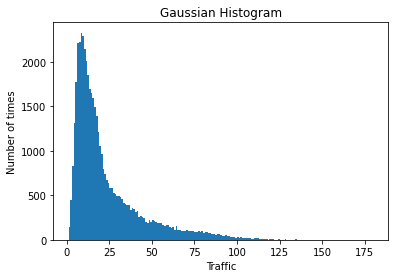

In [66]:
data = train.Vehicles
binwidth = 1
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Traffic")
plt.ylabel("Number of times")
plt.show()

In [67]:
train_features = datetounix(train.drop(['Vehicles','Year', 'Quarter', 'Month'], axis=1))
test_features = datetounix(test.drop(['Year', 'Quarter', 'Month'], axis=1))

X = train_features  
X_test = test_features
X[ 'Junction' ] = X[ 'Junction' ].astype('str')
X[ 'Weekday' ] = X[ 'Weekday' ].astype('str')
X[ 'Day' ] = X[ 'Day' ].astype('str')
X_test[ 'Junction' ] = X_test[ 'Junction' ].astype('str')
X_test[ 'Weekday' ] = X_test[ 'Weekday' ].astype('str')
X_test[ 'Day' ] = X_test[ 'Day' ].astype('str')

X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

y = train['Vehicles'].to_frame()

print("X.shape : ", X.shape)
display_head_tail(X, head_rows=3, tail_rows=2)
display(X.columns)


print("X_test.shape : ", X_test.shape)
display_head_tail(X_test, head_rows=3, tail_rows=2)
display(X_test.columns)

X.shape :  (48120, 45)


'Data Head & Tail :'

,DateTime,Time,Week,Junction_1,Junction_2,Junction_3,Junction_4,Weekday_0,Weekday_1,Weekday_2,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,1.446316e+09,0,44,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.446320e+09,3600,44,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.446323e+09,7200,44,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48118,1.498840e+09,79200,26,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
48119,1.498844e+09,82800,26,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Index(['DateTime', 'Time', 'Week', 'Junction_1', 'Junction_2', 'Junction_3',
       'Junction_4', 'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6', 'Day_1', 'Day_10', 'Day_11',
       'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18',
       'Day_19', 'Day_2', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24',
       'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_3', 'Day_30',
       'Day_31', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9'],
      dtype='object')

X_test.shape :  (11808, 45)


'Data Head & Tail :'

,DateTime,Time,Week,Junction_1,Junction_2,Junction_3,Junction_4,Weekday_0,Weekday_1,Weekday_2,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,1.498847e+09,0,26,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.498851e+09,3600,26,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.498855e+09,7200,26,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11806,1.509467e+09,79200,44,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
11807,1.509471e+09,82800,44,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


Index(['DateTime', 'Time', 'Week', 'Junction_1', 'Junction_2', 'Junction_3',
       'Junction_4', 'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6', 'Day_1', 'Day_10', 'Day_11',
       'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18',
       'Day_19', 'Day_2', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24',
       'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_3', 'Day_30',
       'Day_31', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9'],
      dtype='object')

In [68]:
df_solution = pd.DataFrame()
df_solution['ID'] = test_ID
value = 16
clf = LGBMRegressor(boosting_type='gbdt',max_depth=6,learning_rate=0.25, n_estimators=80, min_split_gain=0.7,reg_alpha=0.00001,random_state = value)
clf = clf.fit(X, y)
predictions = clf.predict(X_test)

In [69]:
df_solution['Vehicles'] = predictions
display(df_solution.head())

,ID,Vehicles
0,20170701001,74.749789
1,20170701011,62.797835
2,20170701021,52.463432
3,20170701031,41.907062
4,20170701041,37.379580
